# Tutorial

The `AtUproot` class is the user interface to the underlying alphatwirl tools which are used to read in and loop over blocks of events.

In this example we will read in Monte Carlo generated events for the production of the Z boson which decays into muons. The mass of the Z is encoded in the inputs and will be plotted as a histogram.

In [1]:
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np

from atuproot.AtUproot import AtUproot

Initialise an instance of `AtUproot` with the desired options:
* `quiet` - suppressed the output to stdout
* `parallel_mode` - option for parallelisation
* `process` - for 'multiprocessing mode. The number of cores to run on
* `max_blocks_per_dataset` - number of blocks per datasets (will either be hzz or zmumu here). A block is a group of events read into a numpy array at once.
* `max_blocks_per_process` - number of blocks per process. A process is a singular unit of the set of parallel jobs.
* `nevents_per_block` - this defines the size of a block. i.e. the number of events to read in to an array
* `profile` - boolean. Profile the code and output the results into `profile_out_path`. To profile the code that operates on the tree then run in 'multiprocessing mode with zero processes (i.e. no parallelisation)
* `profile_out_path` - see above.

In [2]:
process = AtUproot(
    "output",
    quiet = False,
    parallel_mode = 'multiprocessing',
    process = 0,
    max_blocks_per_dataset = -1,
    max_blocks_per_process = -1,
    nevents_per_block = 1000000,
    profile = False,
    profile_out_path = 'profile.txt',
)

We now have to define a few modules to process the contents of the tree.

Here we create a `TestReader` that has no required inheritance and has the following methods:
* `__init__` - initialise whatever you need
* `begin` - runs at the starts of each process with some information on the event (no arrays have been read in yet)
* `end` - runs at the end of each process. Mainly to remove any non-picklable objects such as lambda functions
* `event` - runs on each block of events. The attributes of `event` should include all branches/leaves of the tree (and additional information)
* `merge` - takes `other` which is the a `TestReader` instances from anther process for the same dataset. This should define how to merge the results. Here we just sum the histograms (if they exist)

In [3]:
class TestReader(object):
    def __init__(self):
        self.bins = np.linspace(60., 120., 61)

    def begin(self, event):
        self.hist = None
        print(event.config)
        
    def end(self):
        pass
    
    def event(self, event):
        hist, _ = np.histogram(event.M, self.bins)
        if self.hist is None:
            self.hist = hist
        else:
            self.hist += hist
            
    def merge(self, other):
        if self.hist is None:
            self = other
            return
        if other.hist is None:
            return
        
        self.hist += other.hist

Next is the `TestCollector` class which will be paired with the `TestReader` class. This has one method: `collect`, which takes a `dataset_readers_list` argument. This argument is a list of tuples of all `(dataset, readers)` combinations.

We're running over 1 dataset so we'll take the first item in the list. Then the 2nd item in the tuple (i.e. the readers) and the 1st item in the readers list (we only have 1 reader). Therefore, `reader` will correspond to our `TestReader` for our 1st dataset.

In [4]:
class TestCollector(object):
    def collect(self, dataset_readers_list):
        reader = dataset_readers_list[0][1][0]
        return (reader.bins, reader.hist)

We pass the initialised `TestReader` and `TestCollector` as a list of pairs to `process`

In [5]:
sequence = [(TestReader(), TestCollector())]

Now we need to define our datasets (our inputs). This must be a list of classes or namedtuples with, at least, the attributes: `name` (your chosen name for the dataset), `tree` (tree name within the files) and `files` (list of files for the dataset).

In [6]:
Dataset = namedtuple("Dataset", "name tree files")
hzz = Dataset(name = "hzz",
             tree = "events",
             files = ["HZZ.root"])
zuu = Dataset(name = "zuu",
             tree = "events",
             files = ["Zmumu.root"])
datasets = [zuu] #,hzz]

Everything is setup, we just need to run the whole process as follows. This will return the return values of all our collectors

In [7]:
result = process.run(datasets, sequence)


Fri Sep 28 11:55:12 2018
        0 /        1 (  0.00%) zuu 
EventBuilderConfig(inputPaths=['Zmumu.root'], treeName='events', start_block=0, stop_block=-1, nevents_per_block=1000000, dataset=Dataset(name='zuu', tree='events', files=['Zmumu.root']), name='zuu')

Fri Sep 28 11:55:12 2018
        1 /        1 (100.00%) zuu 


Fri Sep 28 11:55:12 2018
        1 /        1 (100.00%) zuu 
        1 /        1 (100.00%) collecting results 



We want to get the 1st collector of our 1st dataset:

In [8]:
bins, hist = result[0][0]

<BarContainer object of 60 artists>

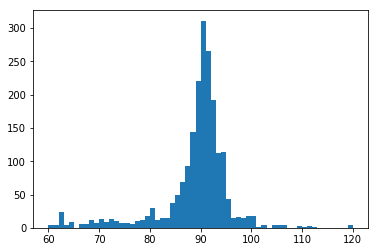

In [9]:
plt.bar(
    (bins[1:]+bins[:-1])/2,
    height = hist,
    width = (bins[1:]-bins[:-1])
)